In [32]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [33]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w")
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
  x = yield tfd.Normal(loc=tf.matmul(w, z),
                       scale=stddv_datapoints,
                       name="x")

In [37]:
# pip install pyreadr

     |████████████████████████████████| 419kB 34.7MB/s 


In [59]:
import pyreadr
data = pyreadr.read_r("UK_all_time_decathlon.RDS")
df=pd.DataFrame(data[None])
df1=df.iloc[1:,:-2]
normalized_df=(df1-df1.mean())/df1.std()
x_train = normalized_df.to_numpy().T
x_train = tf.convert_to_tensor(x_train,dtype=tf.float32)

In [60]:
x_train

<tf.Tensor: shape=(10, 316), dtype=float32, numpy=
array([[ 0.15142976, -0.3241161 ,  0.00282167, ..., -0.1457864 ,
         0.35948107,  1.0133567 ],
       [-0.02889987,  0.29247344, -0.10924319, ...,  0.02466235,
         0.07822457, -0.1360243 ],
       [ 1.6844499 ,  1.5797278 ,  1.048062  , ..., -0.6597133 ,
        -1.2961013 , -1.5780452 ],
       ...,
       [-0.24106863,  0.3324146 , -0.6233908 , ..., -0.33664918,
        -0.48002   , -1.8181475 ],
       [ 0.31934997,  0.7577279 ,  0.15248355, ...,  0.32924885,
         0.42965153, -0.31700504],
       [ 0.33849692,  0.63873965, -0.32698953, ...,  0.16392282,
         0.24749553,  0.58735794]], dtype=float32)>

In [61]:
data_dim, num_datapoints = x_train.shape
latent_dim = data_dim
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

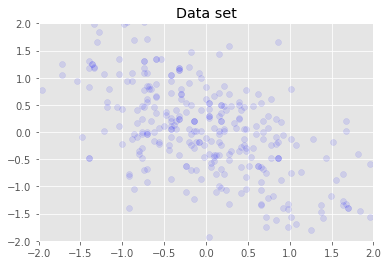

In [62]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-2, 2, -2, 2])
plt.title("Data set")
plt.show()

In [63]:
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=300)

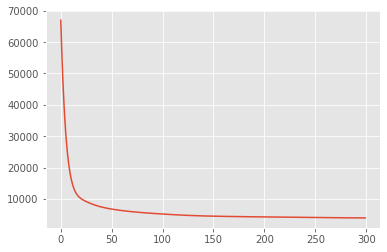

In [64]:
plt.plot(losses)

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(10, 10) dtype=float32, numpy=
array([[-0.16898282,  1.3449194 ,  0.32071993,  1.0008628 ,  0.20845513,
        -1.5169553 ,  0.06064687, -0.88853776,  0.93281436,  0.82352626],
       [-0.7652861 , -0.6491895 ,  0.50364196, -0.17798738, -1.5251987 ,
         1.0117921 , -0.64770687,  0.08466645,  0.23203066, -1.5196311 ],
       [-1.5245075 ,  1.4190917 , -0.01380335, -0.66619295,  0.3573941 ,
         0.18066634,  0.40564337, -0.34384388, -1.1760962 , -0.7016982 ],
       [-0.07249153,  1.7460458 ,  0.7611263 ,  0.82823604, -1.5336975 ,
         1.2169555 , -0.08228498,  0.439551  , -0.42989638,  0.25568894],
       [ 0.49480665, -0.34773532,  2.6061502 , -0.33776727,  0.19718502,
        -0.72996503,  0.30316794, -1.7472262 , -0.1906429 ,  1.3735563 ],
       [-0.06281297,  0.0284184 ,  0.7210196 ,  2.250006  ,  1.0385097 ,
        -0.04460546,  1.0028725 , -0.06909583,  0.6534197 , -0.31765077],
       [-0.8778841 ,  0.84605616,  

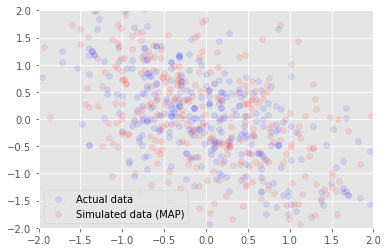

In [66]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-2, 2, -2, 2])
plt.show()

In [67]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=300)

Inferred axes:
<tf.Variable 'Variable:0' shape=(10, 10) dtype=float32, numpy=
array([[-0.1795181 ,  0.00672196, -0.52402866,  0.35155725, -0.10069475,
         0.04295851,  0.3441597 ,  0.06846024, -0.28176197, -0.29049337],
       [ 0.04653167,  0.12414579,  0.28544796, -0.3534904 , -0.14337757,
         0.26550058, -0.52067685,  0.04997483,  0.23720254, -0.10646376],
       [ 0.24203266, -0.38516572,  0.11706008,  0.08914866,  0.42047644,
         0.09515626, -0.27764913,  0.07747027, -0.22994506, -0.21391553],
       [ 0.12756313,  0.10772815,  0.06764165, -0.05629765,  0.04152965,
         1.0571997 , -0.04981807, -0.00738401,  0.15821923, -0.03187946],
       [-0.25741535, -0.15704577, -0.38215724,  0.5141722 ,  0.10919269,
        -0.13430707, -0.07881945, -0.01286738,  0.3233491 ,  0.00379812],
       [ 0.03796371, -0.12872228, -0.41789278,  0.05215004, -0.19535491,
        -0.00745401,  0.44330272,  0.4771048 ,  0.02607818, -0.16077827],
       [ 0.22405346, -0.43838012, -0.183

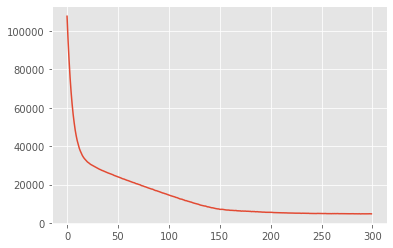

In [68]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

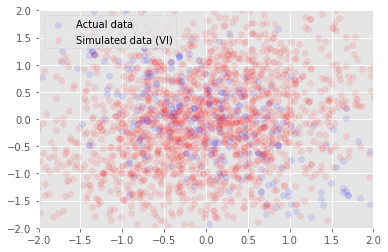

In [69]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-2, 2, -2, 2])
plt.show()

In [79]:
np.savetxt("python_z.csv", qz_mean.numpy().T, delimiter=",")

In [80]:
np.savetxt("python_w.csv", qw_mean.numpy().T, delimiter=",")

In [70]:
qz_mean

<tf.Variable 'Variable:0' shape=(10, 316) dtype=float32, numpy=
array([[ 0.66439027,  1.0630329 ,  0.45495072, ..., -0.41598338,
        -0.53936607, -0.49221656],
       [-1.3615518 , -0.7981175 , -1.3066998 , ...,  0.21183208,
         0.49395567,  0.42856604],
       [-0.5498028 , -0.61195856, -0.30259532, ..., -0.23248486,
        -0.6103162 , -1.0934007 ],
       ...,
       [ 0.12921023,  0.6484503 ,  0.801102  , ...,  0.5233953 ,
         1.3679199 ,  1.1465144 ],
       [-0.6924799 , -0.05423857, -0.16160102, ...,  0.13848679,
         0.21878435,  0.34320292],
       [-0.7707999 , -0.6940951 , -0.34348902, ...,  0.3013902 ,
         0.05679395,  0.9473685 ]], dtype=float32)>

In [71]:
qz_stddv

<TransformedVariable: dtype=float32, shape=[10, 316], fn="softplus", numpy=
array([[0.706302  , 0.5703219 , 0.6168268 , ..., 0.6029664 , 0.5354021 ,
        0.56767076],
       [0.57693565, 0.44296518, 0.47297323, ..., 0.60384554, 0.509267  ,
        0.54037684],
       [0.25252724, 0.3283114 , 0.31901833, ..., 0.32630825, 0.27149922,
        0.3941873 ],
       ...,
       [0.58748126, 0.5805421 , 0.690872  , ..., 0.5018948 , 0.63363457,
        0.6018018 ],
       [0.67463815, 0.6174959 , 0.5572379 , ..., 0.5160292 , 0.6489583 ,
        0.56675375],
       [0.5582491 , 0.6093582 , 0.53327376, ..., 0.66801065, 0.5578821 ,
        0.49908906]], dtype=float32)>